# Algorytmy macierzowe - zadanie nr 2 - Eliminacja Gaussa i LU Faktoryzacja dla macierzy gęstych

"Proszę wybrać język programowania wedle uznania
Proszę napisać procedurę [S]=Schur_Complement(A,n,m)
gdzie A to macierz wejściowa, n to rozmiar tej macierzy A,
m to rozmiar podmacierzy (tzw. dopełnienia Schura),
powstałej poprzez wyeliminowanie n-m wierszy i kolumn
z macierzy A, wykorzystując [zatrzymując po n-m krokach]:
 
6. Faktoryzacja Cholesky’ego “wektorową” (slajd 28) 
"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [65]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import os

Do implementacji wybraliśmy język Python 3 wraz z biblioteką do obliczeń numerycznych numpy, która pozwala operować na macierzach zaimplementowanych bezpośrednio w języku C.

## Generowanie macierzy

Macierze, których będziemy używać, wygenerowaliśmy za pomocą dostarczonej procedury massmatrix, napisanej w środowisku Octave. Macierze zapisaliśmy w postaci pliku tekstowego, a następnie odczytaliśmy w Pythonie za pomocą poniższej funkcji.

In [66]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [67]:
matrix_small = read_matrix('matrices/riga_2.txt')
matrix_small

array([[0.04      , 0.02333333, 0.00333333, 0.        , 0.02333333,
        0.01361111, 0.00194444, 0.        , 0.00333333, 0.00194444,
        0.00027778, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.02333333, 0.06666667, 0.04      , 0.00333333, 0.01361111,
        0.03888889, 0.02333333, 0.00194444, 0.00194444, 0.00555556,
        0.00333333, 0.00027778, 0.        , 0.        , 0.        ,
        0.        ],
       [0.00333333, 0.04      , 0.06666667, 0.02333333, 0.00194444,
        0.02333333, 0.03888889, 0.01361111, 0.00027778, 0.00333333,
        0.00555556, 0.00194444, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00333333, 0.02333333, 0.04      , 0.        ,
        0.00194444, 0.01361111, 0.02333333, 0.        , 0.00027778,
        0.00194444, 0.00333333, 0.        , 0.        , 0.        ,
        0.        ],
       [0.02333333, 0.01361111, 0.00194444, 0.        , 0.06666667,
        0.03888889, 0.00555556, 

* przygotowanie zestawu macierzy do testów:

In [68]:
fem_matrices  = []
riga_matrices = []

for file in os.listdir('matrices'):
    if file.startswith('riga'):
        riga_matrices.append(read_matrix('matrices/' + file))
    if file.startswith('fem'):
        fem_matrices.append(read_matrix('matrices/' + file))

## Faktoryzacja Cholesky'ego i dopełnienie Schura 

wersja z wykładu:

In [69]:
def schur_complement(matrix,  m=0):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n-m):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k+1:n, k]
        dkk = A[k, k]
        A[k+1:n, k] /= dkk
        
        for j in range(k+1, n):
            A[j:n, j] -= A[j:n, k]*vk[n-j-1]
        
    return A

wersja z internetu (działająca):

In [70]:
def schur_complement2(matrix, m=0):
    S = matrix.copy()
    n = S.shape[0]
    L = np.zeros((n, n))
    
    for j in range(n-m):
        L[j, j] = S[j, j]**0.5
        L[j+1:n, j] = S[j+1:n, j]/L[j,j]
        
        for i in range(j+1, n):
            S[i, j+1:n] -= L[i, j]*L[j+1:n, j]
    
    return L

In [71]:
m = np.array([[1, 2, 3, 4], [2, 30, 6, 1], [3, 6, 50, 2], [4, 1, 2, 100]], dtype=float)

In [72]:
print(schur_complement(m, 0))
print(schur_complement2(m, 0))
print(np.linalg.cholesky(m))

[[ 1.          2.          3.          4.        ]
 [ 2.         22.          6.          1.        ]
 [ 3.         -0.27272727 40.81404959  2.        ]
 [ 4.         -0.68181818 -0.25640377 91.7483067 ]]
[[ 1.          0.          0.          0.        ]
 [ 2.          5.09901951  0.          0.        ]
 [ 3.          0.          6.40312424  0.        ]
 [ 4.         -1.37281295 -1.56173762  8.92616156]]
[[ 1.          0.          0.          0.        ]
 [ 2.          5.09901951  0.          0.        ]
 [ 3.          0.          6.40312424  0.        ]
 [ 4.         -1.37281295 -1.56173762  8.92616156]]


W celu weryfikacji poprawności powyższej funkcji, porównujemy wynik z faktoryzacją otrzymaną przy użyciu funkcji biblioteki numpy: 

In [73]:
def cholesky_test(A):
    return np.allclose(schur_complement2(A, 0), np.linalg.cholesky(A))

In [74]:
cholesky_test(matrix_small)

True

### Pomiar czasów

"(...) proszę narysować następujący wykres: <br>
> oś pozioma: rozmiar macierzy n dla liczby przedziałów nxx=2,3,4,… (tak duże macierze ile się uda policzyć na laptopie), <br>
oś pionowa: czas [s] (Octave tic; Schur Complement(...); toc)  

Proszę narysować 

> a) wykres czasu obliczeń dopełnień Schura o rozmiarze n/2
 ** b) wykres czasu obliczeń dopełnień Schura o rozmiarze n/4
 ** c) … takie podziały jakie mają sens do rozmiaru 1"

In [105]:
def compare_times(matrices):
    times = {}
    
    for matrix in matrices:
        n = matrix.shape[0]
        times[n] = {}
        
        start = time()
        schur_complement2(matrix, n//2)
        times[n]['n/2'] = time() - start
        
        start = time()
        schur_complement2(matrix, n//4)
        times[n]['n/4'] = time() - start
        
        start = time()
        schur_complement2(matrix, 1)
        times[n]['1'] = time() - start
        
    df = pd.DataFrame(times).T.sort_index()
    df.plot(
        figsize=(13, 10),
        xlabel='matrix size (n x n)',
        ylabel='time [s]',
        colormap='Accent',
        linewidth=3,
        markersize=10,
        marker='o'
    )
        
    
    return df

* dla macierzy IGA riga=0, pxx=2, rxx=0

,n/2,n/4,1
16,0.000257,0.000315,0.000337
25,0.000665,0.001116,0.000891
36,0.001240,0.001543,0.001655
49,0.007400,0.003231,0.003354
64,0.003900,0.004856,0.005193
81,0.006325,0.007893,0.008354
100,0.009538,0.011896,0.012731
121,0.014170,0.017521,0.018717
144,0.020686,0.025670,0.026848


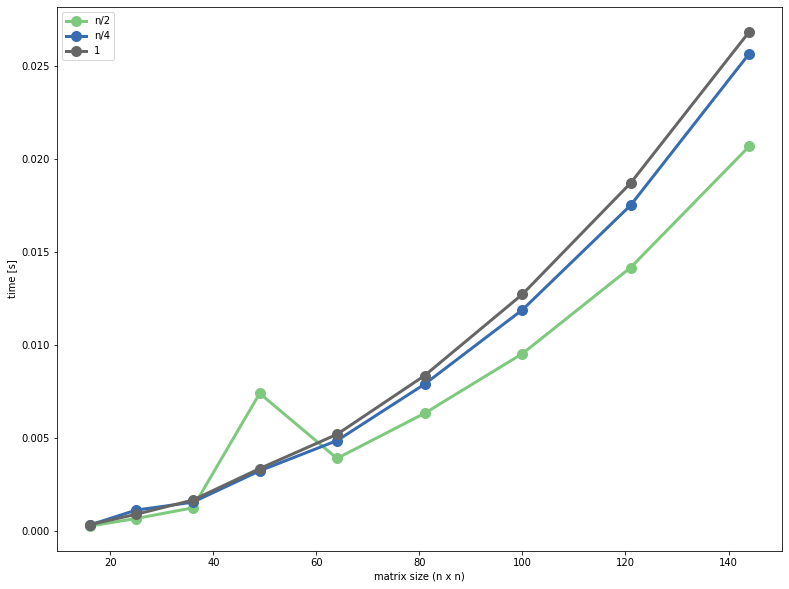

In [106]:
compare_times(riga_matrices)

* dla macierzy FEM riga=1, pxx=2, rxx=0

,n/2,n/4,1
25,0.000660,0.000762,0.000824
49,0.002381,0.003062,0.003158
81,0.006525,0.008116,0.008675
121,0.021455,0.017907,0.018850
169,0.029144,0.036013,0.038102
225,0.053505,0.066641,0.071079
289,0.091515,0.109861,0.116051
361,0.148018,0.180698,0.187855
441,0.223774,0.265795,0.282932
529,0.332270,0.403883,0.443837


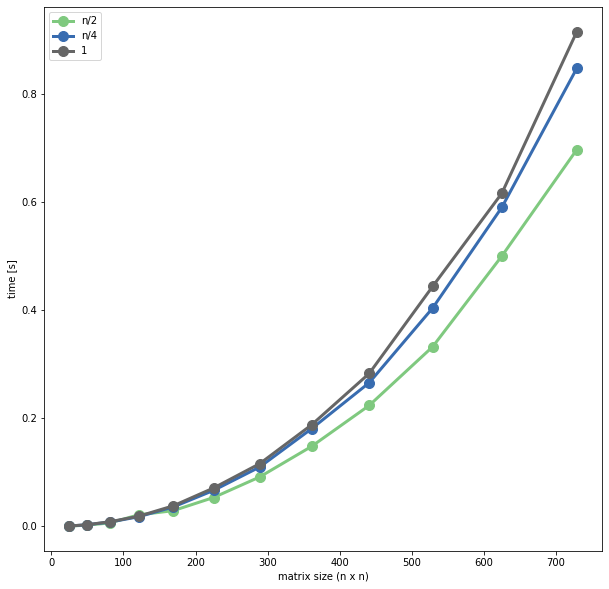

In [100]:
compare_times(fem_matrices)

## Koszt obliczeniowy i pamięciowy

"3. Jaki jest koszt obliczeniowy i pamięciowy (flopsy i memopsy) zaimplementowanego
algorytmu?"

## Wnioski

* 
* 

M. Hawryluk, N. Wolniak. 2021